In [1]:
import cv2
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm.auto import tqdm as notebook_tqdm
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from IPython.display import clear_output
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\drobi\Documents\GitHub\learning-portfolio\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Image Segmentation
Image segmentation partitions an image into regions called segments and creates segments by analyzing some similarity criteria (such as intensity, color, texture, histogram, or features).

### Image Segmentation Methods
- Thresholding (binarization, otsu)
- Region-based (region growing, region splitting)
- Clustering (k-means, mean-shift)
- Graph-based (graph-cut, random walk)
- Shape-based (level set, active contours)
- Energy minimization (MRF)
- Machine Learning-based

# Threshold
### Binarization
Image binarization applies often just one global threshold $T$ for mapping a scalar image $I$ into a binary image with black and white. The global threshold can be identified by an optimization strategy aiming at creating "large" connected regions and reducing the number of small-sized regions, called *artifacts*.

Useful for when the histogram of the intensity levels has a valley where there is not many pixels at the threshold and there are peaks on the left and right of the threshold, representing the darker and brighter objects.

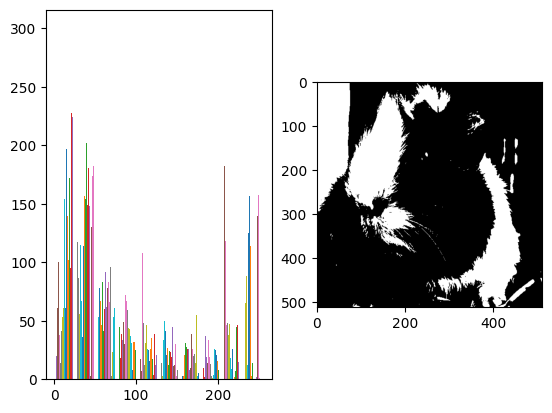

In [2]:
image = cv2.imread("img3.png", cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (512, 512))
image = torch.from_numpy(image).to(device=device, dtype=torch.float).unsqueeze(0)

binarized_image = image > 150

plt.subplot(1, 2, 1)
plt.hist(image.squeeze().cpu().numpy(), bins=10, range=(0, 256))
plt.subplot(1, 2, 2)
plt.imshow(binarized_image.squeeze().cpu().numpy(), cmap='gray')
plt.show()

### Otsu
Otsu uses grey-value histogram of the given image $I$ as input and aims at providing the best threshold
Otsu's algorithm selects a threshold that maximizes the between-class variance $\sigma_b^2$.

For example, with two classes, $\sigma_b^2=P_1(\mu_1-\mu)^2+P_2(\mu_2-\mu)^2=P_1P_2(\mu_1-\mu_2)^2$ where $P_1$ and $P_2$ are the class probabilities, and $\mu_i$ is the means of object and background classes.

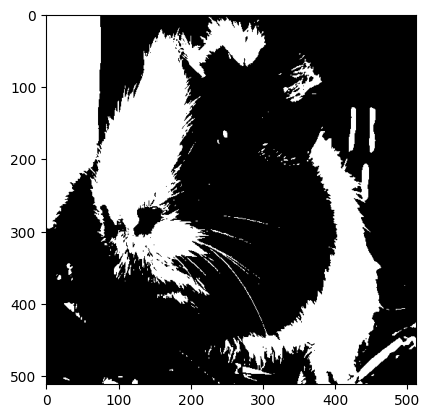

In [3]:
def get_variance(image: torch.Tensor, threshold):
    # Calculate between-class variance with the previous formula
    binarized_image = image > threshold
    P1 = binarized_image.nonzero().shape[0] / image.flatten().shape[0]
    P2 = 1 - P1
    mu1 = image[image > threshold]
    mu1 = 0 if mu1.shape[0] == 0 else mu1.mean()
    mu2 = image[image <= threshold]
    mu2 = 0 if mu2.shape[0] == 0 else mu2.mean()
    return P1 * P2 * (mu1 - mu2) ** 2

best_threshold = -1
best_variance = -1

# Test every integer threshold value to determine threshold with highest between-class variance
for threshold in range(0, 256):
    variance = get_variance(image, threshold)
    
    if variance > best_variance:
        best_variance = variance
        best_threshold = threshold

plt.imshow((image > best_threshold).squeeze().cpu().numpy(), cmap='gray')
plt.show()

# Region-based Methods
### Region Growing
To build a segment, start at one *seed pixel* and recursively add adjacent pixels that satisfy a "similarity criterion" with the pixels already included.

Similarity Criterion:
1. The absolute difference between a candidate pixel and the seed pixel must lie within a specified range
2. The absolute intensity difference between a candidate pixel and the running average intensity of the growing region must lie within a specified range
3. The difference between the standard deviation in intensity over a specified local neighborhood of the candidate pixel and that over a local neighborhood of the candidate pixel must exceed a certain threshold.

### Region Splitting
Start with the whole image as a single region and recursively divide it into sub-regions while a condition of homogeneity is not satisfied.

Construct a region adjacency graph as a quadtree for splitting.

Algorithm:
1. If a region $R$ is inhomogeneous ($P(R)=FALSE$), then $R$ is split into four sub-regions and algorithm is ran on sub-regions
2. If two adjacent regions $R_i$, $R_j$ are homogeneous ($P(R_i\cup R_j)=TRUE$), they are merged
3. The algorithm stops when no further splitting or merging is possible

# Clustering
### K-means
Start with some initial cluster centers, one for each pre-defined category (try out multiple starting points since some seeds can result in poor convergence rate). Loop until none of the centers have changed in an iteration or until a counter is passed:
1. Assign each example to the closest center
2. Recalculate centers as the mean of the points in a cluster

K-means tries to minimize the sum of the squared distances from each point to the associated cluster center.

SLIC Algorithm
1. Initialize cluster centers on pixel grid in steps, $S$
2. Move centers to position in 3x3 window with smallest gradient
3. Compare each pixel to cluster center within $2S$ pixel distance and assign to nearest
4. Recompute cluster centers as mean color/position of pixels belonging to each cluster
5. Repeat steps 3-4 until residual error is small

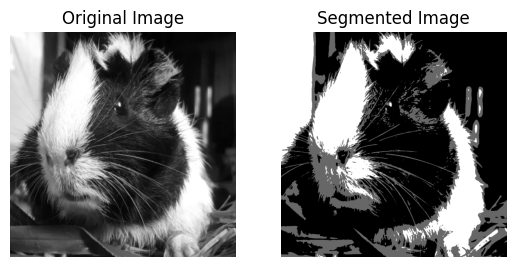

In [4]:
image = cv2.imread('img3.png', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (1024, 1024))
image = torch.from_numpy(image).to(device=device, dtype=torch.float)

height, width = image.shape

segmented_image = image.view((-1, 1))

num_clusters = 3
iterations = 100

indices = torch.randperm(segmented_image.shape[0])[:num_clusters]
centers = segmented_image[indices]

for _ in range(iterations):
    # Assign centers to each pixel
    distances = torch.cdist(segmented_image.unsqueeze(0), centers.unsqueeze(0)).squeeze(0)
    cluster_assignments = torch.argmin(distances, dim=1)

    # Recalculate centers
    new_centers = torch.zeros(num_clusters, device=device, dtype=torch.float)
    
    for i in range(num_clusters):
        cluster_points = segmented_image[cluster_assignments == i]
        new_center = cluster_points.mean() if cluster_points.numel() > 0 else torch.zeros((1), device=device, dtype=torch.float)
        new_centers[i] = new_center
    
    new_centers = new_centers.view((num_clusters, 1))
    if centers.equal(new_centers): break

    centers = new_centers

segmented_image = centers[cluster_assignments].view(1, height, width)

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Segmented Image')
plt.imshow(segmented_image.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')

plt.show()

### Mean-Shift
Attempts to find all possible cluster centers in feature space which resolves the issue with K-means where the number of clusters has to be pre-defined. The mean shift algorithm seeks local maximas of density in the feature space.

1. Choose kernel and bandwidth
2. For each point:
    - Center a window on that point
    - Compute the mean of the data in the search window
    - Center the search window at the new mean location
    - Repeat until window does not move anymore

All of the points will be a part of the cluster that it has converged to.

In [5]:
image = cv2.imread('img4.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (128, 128))
image = torch.from_numpy(image).to(device=device, dtype=torch.float)

radius = 35
height, width, _ = image.shape
epsilon = 0.1
X = image.view(-1, 3)

def mean_shift_step(X: torch.Tensor):
    distances = torch.abs(torch.cdist(X, X))
    neighbors = distances <= radius
    neighbors = neighbors.unsqueeze(2).expand(-1, -1, 3)
    weighted_neighbors = torch.where(neighbors, X, torch.full(X.shape, float('nan'), device=device))
    means = torch.nanmean(weighted_neighbors, dim=1)
    return means

for i in range(100):
    nX = mean_shift_step(X)

    if (torch.abs(X - nX) < epsilon).all().item():
        break

    X = nX

new_image = X.view(height, width, 3)

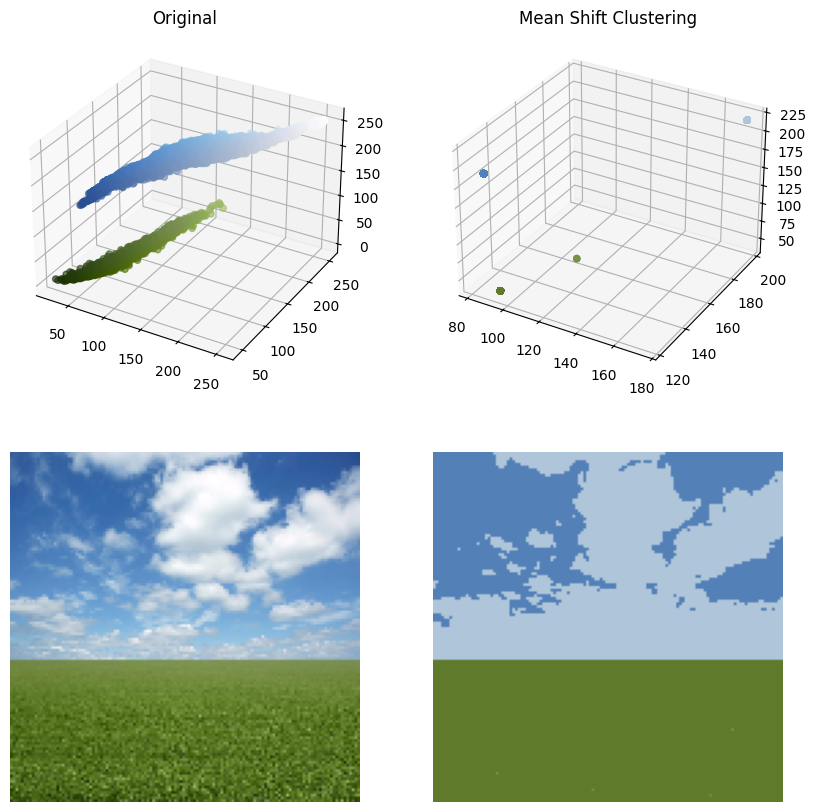

In [6]:
pixels = image.squeeze().cpu().numpy().reshape(-1, 3)
new_pixels = new_image.squeeze().cpu().numpy().reshape(-1, 3)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(221, projection='3d')
ax.scatter(pixels[:, 0], pixels[:, 1], pixels[:, 2], c=pixels/255.0, marker='o', alpha=0.6)
ax.set_title('Original')

ax = fig.add_subplot(222, projection='3d')
ax.scatter(new_pixels[:, 0], new_pixels[:, 1], new_pixels[:, 2], c=new_pixels/255.0, marker='o', alpha=0.6, )
ax.set_title('Mean Shift Clustering')

ax = fig.add_subplot(223)
ax.imshow(image.to(torch.uint8).squeeze().cpu().numpy())
ax.axis('off')

ax = fig.add_subplot(224)
ax.imshow(new_image.to(torch.uint8).squeeze().cpu().numpy())
ax.axis('off')

plt.show()

# Semantic Segmentation
Assigns a label to **each pixel** in an image.

### Upsampling
Used to reverse pooling layers

Method: Bi-linear interpolation
$$f(x, y) = \frac{(x_2 - x)(y_2 - y)}{(x_2 - x_1)(y_2 - y_1)} f(x_1, y_1) + \frac{(x - x_1)(y_2 - y)}{(x_2 - x_1)(y_2 - y_1)} f(x_2, y_1) + \frac{(x_2 - x)(y - y_1)}{(x_2 - x_1)(y_2 - y_1)} f(x_1, y_2) + \frac{(x - x_1)(y - y_1)}{(x_2 - x_1)(y_2 - y_1)} f(x_2, y_2)$$

# Instance Segmentation
Segment each instance of the same class separately.